<a href="https://colab.research.google.com/github/rhea2801/GA_2021/blob/main/working_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a comparative analysis between real encoded fitness function and binary encoded fitness function
for generating a target RGB image from a randomly initialised population of images consisting of the same
amount of pixels.

We evolve individual pixels in each generation, and use crossover and mutation operations, with selecting the
top fitness individuals after each iteration.

Chromosomes are taken as all possible pixel combinations of the given target image size. Genes of the chromosomes
are taken as the individual triples of RGB values, each value ranging from 0 to 255.

For our demonstration we will use images of smaller and larger sizes, along with both fitness functions and analyse the results


# Helper Functions

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import functools
import operator
import random

# as the image has size img_arr.shape[0]*img_arr.shape[1]*3 (3 since we have R,G and B values for each pixel) we use reduce function to multiply these
# three values, which will be the length of the resulting array representation of the image

def img2chromosome(img_arr):
    chromosome = np.reshape(a=img_arr, newshape=(functools.reduce(operator.mul, img_arr.shape)))
    return chromosome

# to convert chromosome to image, we change back the 1D array into a 3D array
def chromosome2img(chromosome, img_shape):
    image = np.reshape(a=chromosome, newshape=img_shape)
    return image


def initiate(img_shape, n_individuals=8):
      # empty population of chromosomes accoridng to the population size specified

    pop = np.empty(shape=(n_individuals, functools.reduce(operator.mul, img_shape)), dtype=np.uint8)
    for i in range(n_individuals):
         # randomly generate initial genes using np.random to get a float between 0 and 1, and then 
         # multiplying by 256 to get the value in RGB scale

        pop[i, :] = np.random.random( functools.reduce(operator.mul, img_shape))*256
    return pop

# for the real fitness, we take the sum of the absolute difference of each R,G and B value of each pixel
# of the target vector and our given individual. but since that would require us to have a minimization
# problem, we instead subtract it from the target so as to turn it into a maximization problem, which is
# what GA's work best on

def fitness_real(target, member):
    fitness = np.mean(abs(target-member))
    fitness = sum(target) - fitness
    return fitness

# for binary fitness, we go gene by gene, and covert it to binary. then consider each bit of target and indiv
# start with fitness = 0. if the bits match, leave it, but if bits are different, then we subtract 1 from fitness
# and divide the total fitness by 2700 for scaling. Hence it becomes a maximization problem

def decimalToBinary(n):
    return bin(n).replace("0b", "")

def fitness_binary(target, indiv_chrom):
  fitness = 0
  for i in range(len(target)):
    target_bin = decimalToBinary(target[i])
    ind_bin = decimalToBinary(indiv_chrom[i])

    # make them both 8 bits long with preceding zeros

    while len(target_bin) < 8:
      target_bin = '0' + target_bin    
    while len(ind_bin) < 8:
      ind_bin = '0' + ind_bin    

     # compute fitness

    for j in range(8):
      if target_bin[j] != ind_bin[j]:
        fitness = fitness - 1
  
  # divide it by length to prevent any overflowing and scale it properly
  fitness = fitness/len(target)
  return fitness

# this function calculates the binary fitness for the entire population and returns it in an array
def fitness_binary_pop(target, pop):
    fitness = np.zeros(pop.shape[0])
    for i in range(pop.shape[0]):
        fitness[i] = fitness_binary(target, pop[i, :])
    return fitness

# this function calculates the real fitness for the entire population and returns it in an array
def fitness_real_pop(target, pop):
    fitness = np.zeros(pop.shape[0])
    for i in range(pop.shape[0]):
        fitness[i] = fitness_real(target, pop[i, :])
    return fitness

# select the top half of best individuals to act as parents for crossover and mutation
def selection(pop, fitness, num_parents):
    parents = np.empty((num_parents, pop.shape[1]), dtype=np.uint8)
    for p in range(num_parents):
        # get the best solution
        fittest_individual = np.where(fitness == np.max(fitness))
        fittest_individual = fittest_individual[0][0]
        parents[p, :] = pop[fittest_individual, :]

        # once selected, we make its fitness -1 so as to guarantee it will not be selected again
        fitness[fittest_individual] = -1
    return parents


# crossover function, returns both the parents and the children
def crossover(parents, img_shape, pop_size):
    new_pop = np.empty(shape=(pop_size, functools.reduce(operator.mul, img_shape)), dtype=np.uint8)

    # old parents remain in the next gen
    new_pop[0:parents.shape[0], :] = parents


    # getting how many offspring to be generated
    # it is the difference between population size and the number of parents that will be mating

    num_children = pop_size - parents.shape[0]
    # getting all possible permutations of the selected parents, and selecting some, to increase randomness
    parents_permutations = list(itertools.permutations(iterable=np.arange(0, parents.shape[0]), r=2))
    selected_permutations = random.sample(range(len(parents_permutations)), num_children)
    
    num_parents = parents.shape[0]

    for permutation_no in range(len(selected_permutations)):
        # generating the offspring
        selected_to_crossover = selected_permutations[permutation_no]
        selected_parents = parents_permutations[selected_to_crossover]
        
        # applying single-point crossover at 1/4th length of the parent arrays

        half_size = np.int32(new_pop.shape[1]/2)
        three_qtr_size = np.int32(new_pop.shape[1]*3/4)
        qtr_size = np.int32(new_pop.shape[1]/4)

        new_pop[num_parents+permutation_no, 0:qtr_size] = parents[selected_parents[0], 
                                                             0:qtr_size]
        new_pop[num_parents+permutation_no, qtr_size:] =  parents[selected_parents[1], 
                                                             qtr_size:]
    
    return new_pop

# we use a low mutation probability of 0.05 %
# we start from num_parents to only use mutation on the offspring
# and avoid it on the parents

def mutation(pop, num_parents_mutating, mut_percent):
    for m in range(num_parents_mutating, pop.shape[0]):
        # select individuals randomly with the probability
        rand_idx = np.uint32(np.random.random(size=np.uint32(mut_percent/100*pop.shape[1]))*pop.shape[1])
        # changing the values of the selected genes randomly
        new_values = np.uint8(np.random.random(size=rand_idx.shape[0])*256)
        # updating population after mutation
        pop[m, rand_idx] = new_values
    return pop

# to show us progress of the algorithm by showing the fittest image

def display_current_iter_image(individuals, im_shape, fitness, iter):
    num_ind = individuals.shape[0]
    best_ind = np.where(fitness ==  fitness.max())
    best_img = chromosome2img(individuals[best_ind, :], im_shape)
    window_name = 'Iteration ' + str(iteration)
    # load image using cv2....and do processing
    plt.imshow(cv2.cvtColor(best_img, cv2.COLOR_BGR2RGB))
    # as opencv loads in BGR format by default, we want to show it in RGB
    plt.show()



# ***Driver Code***


Iteration:  0


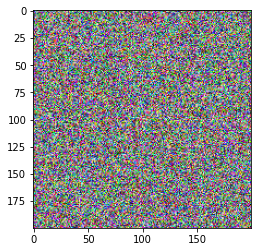

In [ ]:
import os
import sys
import scipy.misc
import cv2
import itertools

# Reading target image to be reproduced using Genetic Algorithm (GA).
target_image = cv2.imread('droid.jfif', 1)
# Target image after enconding. Value encoding is used.
target_chromosome = img2chromosome(target_image)

# Population size
pop_size = 8
# Mating pool size
num_parents_mating = int(pop_size / 2)
# Mutation percentage
mutation_percent = 0.05

# Creating an initial population randomly.
pop = initiate(target_image.shape, pop_size)

for iteration in range(10000):
    # Measing the fitness of each chromosome in the population.
    fitness_array_binary = fitness_binary_pop(target_chromosome, pop)
    
    # Selecting the best parents in the population for mating.
    parents = selection(pop, fitness_array_binary, num_parents_mating)
    
    # Generating next generation using crossover.
    pop = crossover(parents, target_image.shape, pop_size)

    pop = mutation(pop, num_parents_mating, mutation_percent)

    
    # Display the best individual every 1000 generations
    if iteration % 1000 == 0:
      print("\nIteration: ", iteration)
      display_current_iter_image(pop, target_image.shape, fitness_array_binary, iteration)

    